## spaCy Notebook

Here is the notebook that will perform Named Entity Recognition using the spaCy module on the not-parsed data set


### Understanding spaCy
Ultimately it will be useful to use spaCy to find names in the publication statements, but first it is important to see what information spaCy can tell us.
<br><br>
Namely, the *labels* of the *entities*. *Labels* being the type of entity, in the example below the labels are PERSON, ORG, DATE etc. Entities are the nouns or information that the model recognizes as unique and specific. In the below example: Sebastian Thrun, Google, 2007 etc. This is different from any noun such as "companies" or "CEOs" which are not specific *Named Entities* and therefore not picked up by the model.
<br><br>
Example from spaCy website:<br>
text= <br>
("When Sebastian Thrun started working on self-driving cars at "<br>
  "Google in 2007, few people outside of the company took him "<br>
  "seriously. “I can tell you very senior CEOs of major American "<br>
  "car companies would shake my hand and turn away because I wasn’t "<br>
  "worth talking to,” said Thrun, in an interview with Recode earlier "<br>
  "this week.")<br>
  <br>
Entity, Label:
* Sebastian Thrun, PERSON
* Google, ORG
* 2007, DATE
* American, NORP
* Thrun, PERSON
* Recode, ORG
* earlier this week, DATE

In [1]:
# Import Necessary Modules
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
from collections import Counter
# Load spaCy Model
# requires installing the model with python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

#define path for dataframe
printers_data_file_pubstmt_notparsed = 'data/printers_etc_pubstmt_notparsed.csv'
#create Dataframe
pubstmt_df = pd.read_csv(printers_data_file_pubstmt_notparsed)

In [2]:
pubstmt_df

,Unnamed: 0,tcpid,role,role_edited,name,source,title,author,parsedDate,date,place,pubStmt,nameResolved,viafId,namePreprocessed
0,2,A06567,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,Stans puer ad mensam,"Lydgate, John, 1370?-1451?",1476.0,1476?],NaN,"Printed by William Caxton, [Westminster : 1476?]",NaN,NaN,NaN
1,5,A06543,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,[The chorle and the birde],"Lydgate, John, 1370?-1451?",1477.0,1477?],NaN,"W. Caxton, [Westminster : 1477?]",NaN,NaN,NaN
2,6,A06553,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,[The horse the ghoos &amp; the sheep],"Lydgate, John, 1370?-1451?",1477.0,1477?],NaN,"By W. Caxton, [Westminster : 1477?]",NaN,NaN,NaN
3,8,A06569,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,The temple of glas,"Lydgate, John, 1370?-1451?",1477.0,1477?],NaN,"By William Caxton, [Westminster : 1477?]",NaN,NaN,NaN
4,10,A18294,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,If it plese ony man spirituel or temporel to b...,"Caxton, William, ca. 1422-1491.",1477.0,1477?],NaN,"W. Caxton, [Westminster : 1477?]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11371,78087,B27318,bookseller,bookseller,H.H.,tcp_ep,A new summons to Horn-Fair: to appear at Cucko...,NaN,1700.0,[1700?],Black-Fryars,"Printed and sold by H.H. in Black-Fryars, [Lon...",NaN,NaN,NaN
11372,78088,B27318,printer,printer,H.H.,tcp_ep,A new summons to Horn-Fair: to appear at Cucko...,NaN,1700.0,[1700?],Black-Fryars,"Printed and sold by H.H. in Black-Fryars, [Lon...",NaN,NaN,NaN
11373,78091,B28403,publisher,publisher,W.H.,tcp_ep,"The proceedings of the Court of Admiralty, by ...",NaN,1700.0,1700,Fleet-Bridge,"Printed for W.H. near Fleet-Bridge, London : 1700",NaN,NaN,NaN
11374,78100,B43600,publisher,publisher,A.M.,tcp_ep,"The cooper of Norfolk, or, A true jest o'th' b...","M. P. (Martin Parker), d. 1656?",1700.0,[1700?],NaN,Printed by and for W.O. for A.M. and sold by t...,NaN,NaN,NaN


### First Steps

It will be useful to figure out what labels are in the publication statements
<br><br>
The below code does this

In [ ]:
# Define function to print entity labels
def return_entity_labels(text):
    doc = nlp(text)
    label_list = []
    for ent in doc.ents:
        label_list.append((ent.label_, ent.text))
    return label_list
# Print entity labels for each row in pubstmt_df['pubStmt']
for stmt in pubstmt_df['pubStmt'][:100]:
    print(return_entity_labels(stmt))

In [ ]:
#it will also be useful to get a list of all labels
def get_entity_labels(text):
    doc = nlp(text)
    labels = set([ent.label_ for ent in doc.ents])
    return labels

all_labels = set()

# Loop through the 'pubStmt' column and add the entity labels to the set
for stmt in pubstmt_df['pubStmt']:
    labels = get_entity_labels(stmt)
    all_labels.update(labels)

# Print the set of all unique entity labels
print(all_labels)

## Next Step

The results from the first tests show that the labels we have in our Publication Statements are: <br>'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERSON', 'PRODUCT', 'QUANTITY', 'WORK_OF_ART'<br>
The possible labels are: <br> 'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', *'PERCENT'*, 'PERSON', 'PRODUCT', 'QUANTITY', *'TIME'*, 'WORK_OF_ART'

Also, while spaCy is mostly accurate it sometimes confuses labels, for example:
* Antwerp was labeled as a Person
* XXIX was labeled as a Person
* CCCC was labeled as a Geo-political Entity
* Wylliam Caxton was labeled as an Organization

These errors will be important to address in the future, but next step is to add a column in the dataframe for all named entities that could be the publisher.

## Create a Helper Function
This Function takes:
* a statement to search for names in
* and a Named Entity Recognition Model that can test for names

This Function will be used to extract the names

In [13]:
#Define a Function for Name Extraction
def extract_names(statement, ner_model):
    ner_in_statement = ner_model(statement) 
    return [ent.text for ent in ner_in_statement.ents if ent.label_ in ["PERSON"]]

In [14]:
pubstmt_df['namedEntities'] = pubstmt_df['pubStmt'].apply(extract_names, ner_model=nlp)
pubstmt_df['namedEntities']

0        [William Caxton]
1             [W. Caxton]
2             [W. Caxton]
3        [William Caxton]
4             [W. Caxton]
               ...       
11371                  []
11372                  []
11373                  []
11374                  []
11375                  []
Name: namedEntities, Length: 11376, dtype: object

## "Printed by" statements
In a preliminary exploration of the data the most common pubstatement includes one of the following search strings: "printed by", "printed for", "printed, by", "printed, for","prentyd by","enprynted by", or "imprinted by". The below code demonstrates how many statements include

In [3]:
# concatenate all statements into a single string
all_statements = ' '.join(pubstmt_df['pubStmt'])

# define a list of search strings
search_strings = ["printed by", "printed for", "printed, by", "printed, for","prentyd by","enprynted by", "imprinted by"]

# compile a regular expression pattern to match any of the search strings
pattern = re.compile('({0})'.format('|'.join(search_strings)), re.IGNORECASE)

# find all matches of the pattern in the concatenated statements
matches = pattern.findall(all_statements)

# count the number of matches
match_count = len(matches)

# print the result
print(f'Number of matches: {match_count}')
print(f'Number of publication statements: {pubstmt_df.shape[0]}')
print(f'Percent matches: {match_count/pubstmt_df.shape[0]*100:.3f}%')

Number of matches: 9265
Number of publication statements: 11376
Percent matches: 81.443%


## Investigating these statements

In the majority of these statements the next word is "the" followed by a word that describes who is printing the work  <br>
e.g. "**Printed by** *the* **Societie** of Stationers..."<br>
In this example the societie of stationers are the printers and they are, as expected, notated right after the "printed by" and the formula statement <br>
So it will be helpful to see the most common words that follow this statement as it will consitently describe the printers for 81.44% of this dataset. <br>
The below plot does this and finds that the following words are the most common words in these statements:
* widow
* heir
  * heirs
  * Heir
* deputies
* Society
  * Societie of Stationers
* assigns
  * assignes
  * Assigns
* successors
* Printers to the V/University/ie of...
  * printers
* Kings most excellent Majestie
* generall satisfaction of...
* author
* use


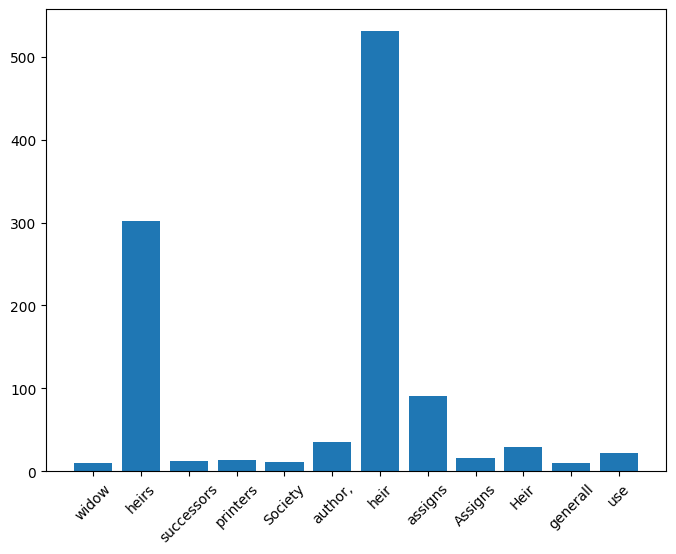

In [4]:
# search strings
search_strings = ["printed by", "printed for", "printed, by", "printed, for","prentyd by","enprynted by", "imprinted by"]

words_list = []
# iterate over search strings and search for them in pubStmt column
for search_str in search_strings:
    mask = pubstmt_df['pubStmt'].str.contains(search_str, case=False)
    if mask.any():
        # if a match is found, extract the three words after the search string and print them
        pubStmt_filtered = pubstmt_df[mask]['pubStmt']
        for pubStmt in pubStmt_filtered:
            search_str_idx = pubStmt.lower().index(search_str)
            words_after = pubStmt[search_str_idx+len(search_str):].split()
            if words_after[0] == 'the' or words_after[0] == 'The':
                words_list.append(words_after[1])
            #print(f"{search_str} {' '.join(words_after[:3])}")
words_counter = Counter(words_list)
cutoff = 10
words_counter = {word: count for word,count in words_counter.items() if count>=cutoff}
words_list, count_list = zip(*words_counter.items())
words_list=list(words_list)

plt.figure(figsize=(8,6))

plt.bar(words_list, count_list)
plt.xticks(rotation=45)
plt.show()


In [14]:
words_counter

{'widow': 10,
 'heirs': 302,
 'successors': 12,
 'printers': 13,
 'Society': 11,
 'author,': 35,
 'heir': 531,
 'assigns': 91,
 'Assigns': 16,
 'Heir': 29,
 'generall': 10,
 'use': 22}

In [22]:
def calculate_word_percentage(df, col_name, search_strings):
    """
    Calculate the percentage of cells in the specified column that contain
    words occurring after one of the specified search strings.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the column to search.
    col_name : str
        The name of the column to search.
    search_strings : list
        The list of search strings to look for in the column.
    cutoff : float
        The minimum percentage of cells that must contain words in order for a
        search string to be considered.
    
    Returns:
    --------
    A dictionary containing the percentage of cells that contain words for each
    search string that met the cutoff.
    """
    word_counts = {}
    total_rows = len(df)
    for search_string in search_strings:
        count = 0
        for pub_stmt in df[col_name]:
            if search_string in str(pub_stmt):
                words = str(pub_stmt).split(search_string)[1].split()
                if len(words) > 0:
                    count += 1
        percentage = (count / total_rows) * 100
        word_counts[search_string] = percentage
    return word_counts
# calculate the percentage of cells containing words for each search string
word_counts = calculate_word_percentage(pubstmt_df, "pubStmt", list(words_counter.keys()))

# print the results
total_percent = 0 # this leads to double counting as of now
for search_string, percentage in word_counts.items():
    print(f"{search_string}: {percentage:.2f}%")
    total_percent +=percentage
print(f'Total Coverage: {total_percent:.2f}%')


widow: 0.23%
heirs: 2.80%
successors: 2.80%
printers: 3.94%
Society: 0.14%
author,: 1.02%
heir: 9.08%
assigns: 1.43%
Assigns: 0.14%
Heir: 0.36%
generall: 0.15%
use: 4.44%
Total Coverage: 26.54%


In [12]:
pubstmt_df['containsName'] = 'unknown'

# Create a function to check if any search term is present in a given string
def check_for_search_terms(string):
    search_terms = ['widow', 'heir', 'deputies', 'society', 'assigns', 'successors', 'Printers to the Universi', 'printers to the Vniversi', 'Kings most excellent Majestie', 'generall satisfaction of']
    for term in search_terms:
        if term.lower() in string.lower():
            return False
    return True

# Apply the function to each row of the DataFrame and update the 'containsName' column
pubstmt_df['containsName'] = pubstmt_df['pubStmt'].apply(lambda x: 'false' if not check_for_search_terms(x) else 'unknown')

# Calculate the percentage of 'false' values in the 'containsName' column
false_percentage = pubstmt_df['containsName'].value_counts(normalize=True)['false'] * 100

# Print the percentage of 'false' values
print(f"Percentage of 'false' values in the 'containsName' column: {false_percentage:.2f}%")


Percentage of 'false' values in the 'containsName' column: 15.34%


In [11]:
# Filter the DataFrame to show only rows where the 'containsName' column is 'false', and select the 'pubStmt' and 'containsName' columns
false_rows = pubstmt_df.loc[pubstmt_df['containsName'] == 'false', ['pubStmt', 'containsName']]

# Display the filtered DataFrame
for row in false_rows['pubStmt']:
    print(row)


By me Theophyll Emlos, vndere the sygne of sente Peters kay [i.e. widow of C. Ruremund, [Printyde at Basyl [i.e. Antwerp] : 1540?]
By Jan Troost [i.e. widow of C. Ruremond], [Printed at Auryk [i.e. Antwerp] : M.D.XLI. in August] [1541]
Printed by the widow of C. Ruremond, [Antwerp : 1543?]
By the Widow of C. Ruremond], [Printed at Wesill in Cliefe lande [i.e. Antwerp : the yere of our Lorde M.D.xliii in the monethe of Iune] [1543]
Printed by the heirs of W. Köpfel], [Strasbourg : A.D. 1556.
Printed by the heirs of W. Köpfel?], [[Strasbourg : 1556]
Printed by the heirs of W. Köpfel], [Strasbourg : 1556.
Printed by the heirs of W. Rihel, [Strasbourg : 1556]
By [the heirs of] Arnold Birckman, Imprinted at Collen : in the yeare of our Lord M.D.LXI. [1561]
By [the heirs of] Arnold Birckman, Imprinted at Collen : in the yeare of our Lorde M.D.LXVIII. [1568]
By the deputies of Christopher Barker, printer to the Queenes most excellent Maiestie, Imprinted at London : [1587]
By the deputies of C

In [20]:
import spacy

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Filter the DataFrame to show only rows where the 'containsName' column is 'unknown'
unknown_rows = pubstmt_df.loc[pubstmt_df['containsName'] == 'unknown']

# Extract names from the 'pubStmt' column using the 'extract_names' function, and update the 'containsName' column
for index, row in unknown_rows.iterrows():
    names = extract_names(row['pubStmt'], nlp)
    if names:
        pubstmt_df.at[index, 'containsName'] = ', '.join(names)
    

# Filter the DataFrame to show only rows where the 'containsName' column is 'false', and select the 'pubStmt' and 'containsName' columns
name_rows = pubstmt_df.loc[(pubstmt_df['containsName'] != 'false') & (pubstmt_df['containsName'] != 'unknown'), ['pubStmt', 'containsName']]

# Display the filtered DataFrame
for row in name_rows['pubStmt']:
    print(row)

Printed by William Caxton, [Westminster : 1476?]
W. Caxton, [Westminster : 1477?]
By W. Caxton, [Westminster : 1477?]
By William Caxton, [Westminster : 1477?]
W. Caxton, [Westminster : 1477?]
Printed by William Caxton, [Westminster : 1477]
W. Caxton, [Westminster : 1477?]
W. Caxton, [Westminster : 1477?]
Printed by William Caxton, [Westminster : 1478]
W. Caxton, [Westminister : 1480]
Printed by William Caxton, [Westminster : 1480]
Printed by William Caxton, [Westminster : after 2 July 1482]
Enprynted by me William Caxton in thabbey of Westme[n]stre by london, [London : fynysshed, and accomplysshed the, viij, day of October, the yere of the incatnacyon of our lord God, M,CCCC,lxxxij and in the xxii yere of the regne of Kyng Edward the fourth [1482]]
By me willyam Caxton, [Enprynted at westmestre : and fynysshed the ij day of Septembre the fyrst yere of the regne of Kyng Richard the thyrd, [i.e. 1483] the yere of our lord a thousand, CCCC, lxxxxiij [sic]]
Per me Wilhelmum de Mechlinia im

In [21]:
name_rows

,pubStmt,containsName
0,"Printed by William Caxton, [Westminster : 1476?]",William Caxton
1,"W. Caxton, [Westminster : 1477?]",W. Caxton
2,"By W. Caxton, [Westminster : 1477?]",W. Caxton
3,"By William Caxton, [Westminster : 1477?]",William Caxton
4,"W. Caxton, [Westminster : 1477?]",W. Caxton
...,...,...
11361,"Printed by Charles Bill, and the executrix of ...","Charles Bill, Thomas Newcomb"
11362,Printed by and for W.O. and are to be sold by ...,C. Bates
11364,"Printed by and for Benj. Harris, next the Gold...","Benj, Harris"
11365,"Printed for H.N. and sold by W. Keble ..., Lon...",W. Keble


In [22]:
# Calculate the percentage of 'false' values in the 'containsName' column
false_percentage = pubstmt_df['containsName'].value_counts(normalize=True)['false'] * 100
unknown_percentage = pubstmt_df['containsName'].value_counts(normalize=True)['unknown'] * 100
names_percentage = 100 - false_percentage - unknown_percentage


# Print the percentage of 'false' values
print(f"Percentage of 'false' values in the 'containsName' column: {false_percentage:.2f}%")
print(f"Percentage of 'names' values in the 'containsName' column: {names_percentage:.2f}%")
print(f"Percentage of 'unknown' values in the 'containsName' column: {unknown_percentage:.2f}%")

Percentage of 'false' values in the 'containsName' column: 15.34%
Percentage of 'unknown' values in the 'containsName' column: 25.79%
Percentage of 'names' values in the 'containsName' column: 58.87%
